In [20]:
import os
os.environ['OPENBLAS_NUM_THREADS'] = '1'       #Disactivate multiprocessing for numpy
import numpy as np
import matplotlib.pyplot as plt
import json
import gymnasium as gym
import yaml
from datetime import datetime
from tqdm import tqdm

import stable_baselines3

from stable_baselines3.common.env_checker import check_env
from stable_baselines3.common.env_util import make_vec_env
from stable_baselines3.common.vec_env import VecNormalize, SubprocVecEnv,VecCheckNan
from stable_baselines3 import PPO, A2C, SAC, TD3
from stable_baselines3.common.evaluation import evaluate_policy
from stable_baselines3.common.noise import NormalActionNoise, OrnsteinUhlenbeckActionNoise
from stable_baselines3.common.callbacks import EvalCallback, CallbackList, CheckpointCallback, StopTrainingOnNoModelImprovement

from sogym.mmc_optim import run_mmc
from sogym.env import sogym
from sogym.expert_generation import generate_expert_dataset, generate_mmc_solutions, generate_dataset
from sogym.utils import profile_and_analyze,ImageDictExtractor, CustomBoxDense
from sogym.callbacks import FigureRecorderCallback, MaxRewardCallback, GradientNormCallback, GradientClippingCallback
from sogym.pretraining import pretrain_agent, ExpertDataSet

import torch
import torch as th
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR
from torch.utils.data import random_split, Dataset
from IPython.display import display
import multiprocessing

%load_ext autoreload
%autoreload 2

print('SB3 version:', stable_baselines3.__version__)
# Let's make the code device agnostic:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print('Using device:', device)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
SB3 version: 2.2.1
Using device: cuda


---
### Environment test and visualization:

In [21]:
# Let's test the environment using the check_env util from SB3:
observation_type = 'topopt_game'
train_env = sogym(mode='train',observation_type=observation_type,vol_constraint_type='hard',resolution=50,check_connectivity = True)
eval_env = sogym(mode='test',observation_type=observation_type,vol_constraint_type='hard',resolution=50,check_connectivity=False)

<Figure size 950x650 with 0 Axes>

<Figure size 950x650 with 0 Axes>

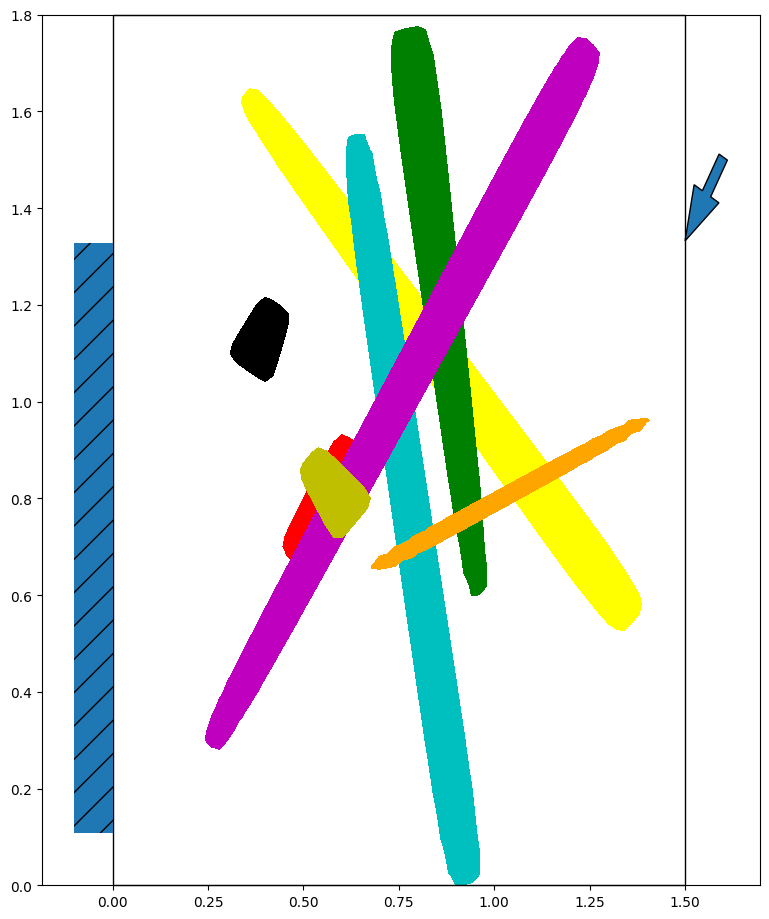

In [17]:
%matplotlib inline

reward = 0.0
# while reward == 0.0:
obs, info = train_env.reset()
dones = False
while not dones:
    action = train_env.action_space.sample()
    obs, reward, dones, truncated, info = train_env.step(action)

train_env.plot()

In [18]:
# It will check your custom environment and output additional warnings if needed
check_env(sogym(mode='train',observation_type='topopt_game'))

<Figure size 750x900 with 0 Axes>

In [ ]:
#Profiling the environment
# # Specify the number of episodes to run
num_episodes = 20
result_df = profile_and_analyze(num_episodes, train_env)
result_df.head()

---
### Multiprocessing

In [22]:
# Set number of CPUs to use automatically
num_cpu = multiprocessing.cpu_count()
num_cpu = 2
print(f"Using {num_cpu} CPUs!")

algorithm_name = "PPO"  # or "TD3"

# Load the YAML file and extract parameters
with open("algorithms.yaml", "r") as file:
    config = yaml.safe_load(file)

common_params = config.get("common", {})
algorithm_params = config.get(algorithm_name, {})

# Define other parameters
params = {
    'observation_type': "topopt_game",
    'vol_constraint_type': "hard",
    'use_std_strain': False,
    'check_connectivity': True,
    'resolution': 50
}

current_datetime = datetime.now().strftime("%Y%m%d_%H%M%S")
train_critic_only = False  # if True, we freeze everything except the critic
pretrained_run = None
restart_run = None  # or "PPO_20240516_093938"

log_name = restart_run if restart_run else f"{algorithm_name}_{current_datetime}"

# Create directory and config file if needed
log_dir = f'./runs/{log_name}'
if not os.path.exists(log_dir):
    os.makedirs(log_dir)
    # Combine all parameters for saving to the config file
    save_params = {**algorithm_params, **params, 'algorithm_name': algorithm_name, **common_params}
    with open(f'{log_dir}/config.yaml', 'w') as file:
        yaml.dump(save_params, file)

# Create training and evaluation environments
train_env = sogym(mode='train', **params)
env = make_vec_env(lambda: train_env, n_envs=num_cpu, vec_env_cls=SubprocVecEnv)
env = VecCheckNan(env, raise_exception=True)

eval_env = sogym(mode='test', **params)
eval_env = make_vec_env(lambda: eval_env, n_envs=1, vec_env_cls=SubprocVecEnv)


Using 2 CPUs!


<Figure size 950x650 with 0 Axes>

<Figure size 950x650 with 0 Axes>

--- 
### Defining the model

In [76]:
# The noise objects for TD3
n_actions = env.action_space.shape[-1]
action_noise = NormalActionNoise(mean=np.zeros(n_actions), sigma=0.5 * np.ones(n_actions))

chosen_policy = "MlpPolicy" if observation_type == 'box_dense' else "MultiInputPolicy"
feature_extractor = ImageDictExtractor if observation_type == 'image' or observation_type=="topopt_game" else CustomBoxDense


policy_kwargs = dict(
    features_extractor_class=feature_extractor,
    net_arch = config['common']['net_arch'],
    share_features_extractor = False,
)

# Create the model based on the algorithm name and parameters
if algorithm_name == "SAC":
    model = SAC(env=env,
                policy = chosen_policy, 
                policy_kwargs=policy_kwargs,
                #action_noise = action_noise,
                ent_coef = 0.0,
                device=device, 
                **algorithm_params)

elif algorithm_name == "PPO":
    model = PPO(env=env, 
                policy = chosen_policy, 
                policy_kwargs=policy_kwargs,
                n_steps= 64*386 // num_cpu//100,
                batch_size= 16384//4,
                tensorboard_log  ='./runs/{}'.format(log_name),
                device = device, 
                **algorithm_params)

elif algorithm_name == "TD3":
    # Create the action noise object
    n_actions = env.action_space.shape[-1]
    action_noise_params = algorithm_params.pop("action_noise")
    action_noise = NormalActionNoise(mean=action_noise_params["mean"] * np.ones(n_actions),
                                     sigma=action_noise_params["sigma"] * np.ones(n_actions))
    model = TD3(env=env,
                policy =chosen_policy, 
                policy_kwargs=policy_kwargs,
                action_noise=action_noise,
                device=device, 
                **algorithm_params)

if load_from_pretrained and pretrained_checkpoint is not None:
    model.set_parameters(pretrained_checkpoint)

if restart_run:
    model = model.load("./runs/{}/checkpoints/best_model.zip".format(log_name),env=env)

/home/thomas/anaconda3/envs/SB3_update/lib/python3.10/site-packages/stable_baselines3/ppo/ppo.py:155: UserWarning: You have specified a mini-batch size of 4096, but because the `RolloutBuffer` is of size `n_steps * n_envs = 246`, after every 0 untruncated mini-batches, there will be a truncated mini-batch of size 246
We recommend using a `batch_size` that is a factor of `n_steps * n_envs`.
Info: (n_steps=123 and n_envs=2)
  warnings.warn(


FileNotFoundError: [Errno 2] No such file or directory: 'runs/PPO_20240516_110357/checkpoints/best_model.zip.zip'

In [72]:
# Save a checkpoint every 1000 steps
checkpoint_callback = CheckpointCallback(
  save_freq=250_000//num_cpu,
  save_path="./runs/{}/checkpoints/".format(log_name),
  name_prefix=log_name,
  save_replay_buffer=True,
  save_vecnormalize=True,
)

eval_callback = EvalCallback(eval_env,
                             log_path='./runs/{}/'.format(log_name), 
                             eval_freq=10_000//num_cpu,
                             deterministic=True,
                             n_eval_episodes=10,
                             render=False,
                             best_model_save_path='./runs/{}/checkpoints/'.format(log_name),
                             verbose=0)

callback_list = CallbackList([eval_callback,
                         checkpoint_callback,
                         MaxRewardCallback(verbose=1),
                         GradientClippingCallback(clip_value=1.0, verbose=1),
                         GradientNormCallback(verbose=1),
                         FigureRecorderCallback(eval_env=eval_env, check_freq=10_000//num_cpu, figure_size=(8, 6))
                         ])

--- 
### Training

In [73]:

def init_weights(m):
    if isinstance(m, nn.Linear):
        nn.init.xavier_uniform_(m.weight)
        if m.bias is not None:
            nn.init.zeros_(m.bias)

if train_critic_only:
    #Freeze everything:
    for name, param in model.policy.named_parameters():
        if param.requires_grad:
            param.requires_grad=False

    if algorithm_name =='SAC':
        # Unfreeze critic:
        for param in model.policy.critic.parameters():
            if param.requires_grad==False:
                param.requires_grad=True

        for param in model.policy.critic_target.parameters():
            if param.requires_grad==False:
                param.requires_grad=True


    if algorithm_name == 'PPO':
        for param in model.policy.mlp_extractor.value_net.parameters():
            if param.requires_grad==False:
                param.requires_grad=True
            
        for param in model.policy.value_net.parameters():
            if param.requires_grad==False:
                param.requires_grad=True

In [74]:

model.learn(25_000_000,
           callback=callback_list, 
           tb_log_name=log_name,
           reset_num_timesteps=not restart
           )

# save the model:
model.save('./runs/{}/checkpoints/final_model')
if algorithm_name != 'PPO':
    model.save_replay_buffer("./runs/{}/checkpoints/final_buffer")


/home/thomas/anaconda3/envs/SB3_update/lib/python3.10/site-packages/stable_baselines3/common/callbacks.py:414: UserWarning: Training and eval env are not of the same type<stable_baselines3.common.vec_env.vec_check_nan.VecCheckNan object at 0x7fca48ac2290> != <stable_baselines3.common.vec_env.subproc_vec_env.SubprocVecEnv object at 0x7fca511b7640>
  warnings.warn("Training and eval env are not of the same type" f"{self.training_env} != {self.eval_env}")
/home/thomas/anaconda3/envs/SB3_update/lib/python3.10/site-packages/gymnasium/core.py:311: UserWarning: WARN: env.reward to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.reward` for environment variables or `env.get_wrapper_attr('reward')` that will search the reminding wrappers.
  logger.warn(
/home/thomas/anaconda3/envs/SB3_update/lib/python3.10/site-packages/gymnasium/core.py:311: UserWarning: WARN: env.reward to get variables from other wrappers is deprecat

KeyboardInterrupt: 

---
### Let's visualize the agent's performance:

In [19]:
viz_env=sogym(mode='test',observation_type='topopt_game',vol_constraint_type='hard' ,resolution = 50)

In [22]:
obs,info=viz_env.reset()
dones=False
saved_conditions = viz_env.conditions
saved_nelx, saved_nely, saved_dx, saved_dy = viz_env.nelx, viz_env.nely, viz_env.dx, viz_env.dy

#use deepcopy to save 
while dones== False:
    action, _states = model.predict(obs,deterministic=True)
    print(action)
    obs, rewards, dones,truncated, info = viz_env.step(action)
print("Desired volume:",saved_conditions['volfrac'],"Obtained volume:",viz_env.volume)
print("Env reward:",rewards)
fig = viz_env.plot()
fig.savefig('trained_agent.png', dpi=300)

[-0.75501883 -1.          0.32291675  0.64145327  0.9568924   0.9920023 ]
[-0.903395    0.6623455  -0.42170578 -0.5872051   0.7409822   0.8139564 ]
[-0.94604313 -0.02086864  0.11097331  1.          0.8015071   0.8562474 ]
[-1.          1.          0.08024888 -0.32997712  1.          1.        ]
[ 0.07595539 -0.7214547   0.4731991   0.3694167   0.37574175  0.34123728]
[-0.37390336 -0.01163775  0.40241554 -0.27844983  0.45322505  0.43657506]
[-0.16364224 -0.55042976  0.31846595  1.          0.4676532   0.45424548]
[-0.12401124  0.69860417  0.35660243 -0.06428144  0.7142122   0.7212964 ]
Desired volume: 0.41 Obtained volume: 0.30805051633717917
Env reward: 0.1713260659137914


In [34]:
mean_reward, std_reward = evaluate_policy(model.policy, eval_env, n_eval_episodes=10, deterministic=True)
print(mean_reward)

/home/thomas/anaconda3/envs/SB3_update/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:67: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


0.07606540508568287


In [ ]:
xval, f0val,it, H, Phimax, allPhi, den, N, cfg = run_mmc(saved_conditions,saved_nelx,saved_nely,saved_dx,saved_dy,plotting='contour')